In [2]:
library(data.table)
library(Rmisc)
library(ggplot2)
library(dplyr)
library(reshape2)
library(bit)
library(zoo)

## 1. Read raw data and merge them

In [3]:
DIR = "../data/"

rws=fread(paste0(DIR,"rws.all.csv"))
ls.hn.ner=fread(paste0(DIR,"df_listings_host_name_extended.csv"))
rws=merge(rws,ls.hn.ner, by="listing_id",type="left")

guest=fread(paste0(DIR,"guest.attribute.csv"))
colnames(guest)[c(8)]=c("g.ethnicity")
guest=guest[,c("guest_id","g.ethnicity")]
rws.gh=left_join(rws,guest, by="guest_id")

#-Note that h.num_face==0 represents hots without any human face in their profile photos.
#-In this case, h.ethnicity is empty string.
#-Additional filtering is required depending on analysis,
#-since profile photos with more than 1 human face also have empty string in the h.ethnicity column.
host=fread(paste0(DIR,"host.attribute.csv"))
colnames(host)[c(5,8)]=c("h.num_face","h.ethnicity")
host=host[,c("listing_id","host_id","h.num_face","h.ethnicity")]
rws.gh=left_join(rws.gh,host, by=c("listing_id","host_id"))

tmp_host=host
tmp_host$h.ethnicity=ifelse(tmp_host$h.num_face==0, "RA", tmp_host$h.ethnicity)

#-Remove those racially unidentified guests
rws.gh=rws.gh[rws.gh$g.ethnicity!="",]

#-Label RA for racially ambiguous hosts
rws.gh$h.ethnicity=ifelse(rws.gh$h.num_face==0, "RA", rws.gh$h.ethnicity)

#-Remove those racially unidentified hosts (with multiple human faces in their profile photos)
rws.gh=rws.gh[rws.gh$h.ethnicity!="",]

## 2. Process reputation and endorsement signals

In [4]:
df=rws.gh

df=df %>% group_by(listing_id) %>% arrange(date) %>%
  mutate(cum.cnt=row_number()-1,
         rws.race=lag(g.ethnicity, n = 1, default = NA))

#-Create column and add counter
df$g.W.cnt=ifelse(df$rws.race=="WHITE", 1, 0)
df$g.B.cnt=ifelse(df$rws.race=="BLACK", 1, 0)
df$g.A.cnt=ifelse(df$rws.race=="ASIAN", 1, 0)

#-Sort reviews for each listing by date
#-Then roll sum racial compositions in the most recent 6 reviews for each booking
#-Note that the most 6 reviews are the proxy of front-page reviews
df = df %>% group_by(listing_id) %>% arrange(date) %>%
    mutate(top6.W=rollsumr(g.W.cnt==1, 6, fill=NA),
           top6.B=rollsumr(g.B.cnt==1, 6, fill=NA),
           top6.A=rollsumr(g.A.cnt==1, 6, fill=NA))

#-Code the first review's the most recent previous reviewer's race as 0
#-and then count all the previous reviewers' races cumulatively
df$rws.race[which(is.na(df$rws.race))]=0

df = df %>% group_by(listing_id) %>% arrange(date) %>% 
    mutate(g.W.cnt=cumsum(rws.race=="WHITE"),
           g.B.cnt=cumsum(rws.race=="BLACK"),
           g.A.cnt=cumsum(rws.race=="ASIAN"))

## 3. Screen instant bookings and split data into different time periods

In [5]:
df=as.data.table(df)

#-Extract only listings that allow instant booking
df=df[which(df$instant_bookable=="t"),]

In [6]:
#-Booking in 2017 and later among listings that appeared in 2017 and later
df.recent.by.new=df
df.recent.by.new$first.date=with(df, ave(date, listing_id, FUN = function(x) x[1]))
                                  
l.listing.recent=df.recent.by.new[df.recent.by.new$first.date >= as.Date("2017-01-01")]$listing_id
df.recent.by.new=df.recent.by.new[df.recent.by.new$listing_id %in% l.listing.recent,]

In [7]:
#-Booking in 2017 and later among listings that appeared before 2017
df.recent.by.old=df
df.recent.by.old$first.date=with(df, ave(date, listing_id, FUN = function(x) x[1]))

l.listing.old=df.recent.by.old[df.recent.by.old$first.date < as.Date("2017-01-01")]$listing_id
df.recent.by.old=df.recent.by.old[df.recent.by.old$listing_id %in% l.listing.old,]
df.recent.by.old=df.recent.by.old[df.recent.by.old$date >= as.Date("2017-01-01")]

In [9]:
wilcox.test(df.recent.by.old$cum.cnt, df.recent.by.new$cum.cnt, alternative="two.sided")

mean(df.recent.by.old$cum.cnt)
mean(df.recent.by.new$cum.cnt)


	Wilcoxon rank sum test with continuity correction

data:  df.recent.by.old$cum.cnt and df.recent.by.new$cum.cnt
W = 3035884340, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


[1] 49.57598

[1] 11.35908

In [10]:
#-Bookings before 2017 & in 2017 and after
tmp_before.2017 = df[df$date < as.Date("2017-01-01")]
max(tmp_before.2017$date)
tmp_2017_and_after = df[df$date >= as.Date("2017-01-01")]
min(tmp_2017_and_after$date)

[1] "2016-12-31"

[1] "2017-01-01"

# ----------------------------------------------------------------------------------------

In [11]:
create_ctf_1 = function(df.x) {
    df.tmp.ctf=df.x
    df.tmp.ctf$pairing.status=0
    df.tmp.ctf$g.ethnicity=ifelse(df.tmp.ctf$g.ethnicity=="BLACK" |
                                  df.tmp.ctf$g.ethnicity=="ASIAN",
                                  "WHITE", "BLACK")
    return(df.tmp.ctf)
}

create_ctf_2 = function(df.x) {
    df.tmp.ctf=df.x
    df.tmp.ctf$pairing.status=0
    df.tmp.ctf$g.ethnicity=ifelse(df.tmp.ctf$g.ethnicity=="BLACK" |
                                  df.tmp.ctf$g.ethnicity=="WHITE",
                                  "ASIAN", "BLACK")
    return(df.tmp.ctf)
}

create_ctf = function(df.x) {
    return(rbind(create_ctf_1(df.x),create_ctf_2(df.x)))
}

## Fig. S8A,D,G

- Replications of **Fig. 1** in the main

### 1.1 Choose sample

- Fully computed normed probabilities are available (check ***1.3*** without running code in ***1.2***)

In [65]:
df.tmp.obs=tmp_before.2017[, c("h.ethnicity", "g.ethnicity"), with=FALSE]
filename_obs="supp_fig_s8a_pairing.prob.obs_before_2017.RDS"
filename_diff="supp_fig_s8a_pairing.prob.diff_before_2017.RDS"
filename_pdf="supp_fig_s8a.pdf"

# df.tmp.obs=df.recent.by.old[, c("h.ethnicity", "g.ethnicity"), with=FALSE]
# filename_obs="supp_fig_s8d_pairing.prob.obs_recent_by_old.RDS"
# filename_diff="supp_fig_s8d_pairing.prob.diff_recent_by_old.RDS"
# filename_pdf="supp_fig_s8d.pdf"

# df.tmp.obs=df.recent.by.new[, c("h.ethnicity", "g.ethnicity"), with=FALSE]
# filename_obs="supp_fig_s8g_pairing.prob.obs_recent_by_new.RDS"
# filename_diff="supp_fig_s8g_pairing.prob.diff_recent_by_new.RDS"
# filename_pdf="supp_fig_s8g.pdf"

### 1.2 Compute normed probabilities for guest-host pairing combinations

In [40]:
df.tmp.obs$pairing.status=1
df.tmp.ctf=create_ctf(df.tmp.obs)

df.obs.ctf=rbind(df.tmp.obs,df.tmp.ctf)
summary.pairing.prob.obs=summarySE(df.obs.ctf, measurevar="pairing.status",
                                   groupvars=c("h.ethnicity", "g.ethnicity"))

df.tmp.rnd=df.tmp.obs

#-Permutate g.ethnicity for n times to create a random baseline
#-to compare the difference between obeservations and random chances
#-as well as to create standard errors... .

start_time=Sys.time()

shuffle_time=1000
l_rand=list()
l_diff=list()
for(x in 1:shuffle_time){
    df.tmp=df.tmp.rnd
    df.tmp$g.ethnicity=df.tmp.rnd[sample(nrow(df.tmp.rnd), replace=FALSE),]$g.ethnicity
        
    df.tmp.ctf=create_ctf(df.tmp)
    df.tmp.rnd.ctf=rbind(df.tmp,df.tmp.ctf)
    
    df.tmp.pairing.prob.obs=summarySE(df.tmp.rnd.ctf, measurevar="pairing.status",
                                      groupvars=c("h.ethnicity", "g.ethnicity"))
    l_rand[[paste("g.rnd.ethnicity", x, sep=".")]]=df.tmp.pairing.prob.obs
    df.tmp.diff=df.tmp.pairing.prob.obs[,1:2]
    df.tmp.diff$prob.diff=summary.pairing.prob.obs$pairing.status - df.tmp.pairing.prob.obs$pairing.status
    l_diff[[paste("obs.rnd.diff", x, sep=".")]]=df.tmp.diff
}

df.pairing.prob.diff=do.call(rbind.data.frame, l_diff)

#-Save
saveRDS(summary.pairing.prob.obs, paste0(DIR,filename_obs))
saveRDS(df.pairing.prob.diff, paste0(DIR,filename_diff))

end_time=Sys.time()
end_time - start_time

Time difference of 1.463654 mins

### 1.3 Visualize normed probabilities by race of guest and host

In [66]:
df.pairing.prob.diff=readRDS(paste0(DIR,filename_diff))

In [67]:
summary.pairing.prob.diff=summarySE(df.pairing.prob.diff, measurevar="prob.diff",
                                    groupvars=c("h.ethnicity", "g.ethnicity"))

summary.pairing.prob.diff$ci=summary.pairing.prob.diff$sd*1.96

summary.pairing.prob.diff$h.ethnicity=ifelse(summary.pairing.prob.diff$h.ethnicity=="RA",
                                             "Racially\nUnidentified", summary.pairing.prob.diff$h.ethnicity)

re_from="\\b([[:alpha:]])([[:alpha:]]+)"
summary.pairing.prob.diff$h.ethnicity=gsub(re_from, "\\U\\1\\L\\2", summary.pairing.prob.diff$h.ethnicity, perl=TRUE)

summary.pairing.prob.diff$h.ethnicity=factor(summary.pairing.prob.diff$h.ethnicity,
                                             levels=c("Racially\nUnidentified","White","Asian","Black"),
                                             ordered=TRUE)

summary.pairing.prob.diff$g.ethnicity=factor(summary.pairing.prob.diff$g.ethnicity,
                                             levels=c("WHITE","ASIAN","BLACK"),
                                             ordered=TRUE)

In [68]:
l_guest.race.label=c(
    "BLACK"="Black Guest",
    "WHITE"="White Guest",
    "ASIAN"="Asian Guest")

dodge=position_dodge(width=0.5)
pdf(paste0("../output/",filename_pdf), width=3.17, height=5)
g = ggplot(summary.pairing.prob.diff, aes(x=h.ethnicity, y=prob.diff)) + 
  xlab("Host Race") + 
  ylab("Pairing Probability Compared to Random") +
  geom_point(position=dodge, size=2.5) +
  geom_errorbar(aes(ymin=prob.diff-ci, ymax=prob.diff+ci),
                size=0.75, width=0.25, position=dodge) +
  facet_grid(~g.ethnicity, margins=FALSE, switch="y",
             labeller=as_labeller(l_guest.race.label)) + theme_classic() +
  scale_y_continuous(limits=c(-0.08,0.08), breaks=seq(-0.08,0.08,0.02),
                     labels=c(seq(-0.08,0.08,0.02))) +
  theme(panel.border=element_rect(fill=NA, size=0.3),
        panel.grid.major=element_blank(),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.4)) +
  geom_hline(yintercept=0, linetype="dashed", color="#D55E00") +
  scale_color_grey(start=0.5, end=0.5) + theme(text=element_text(size=10))
plot(g)
dev.off()

pdf 
  2

In [69]:
fig_a = g
# fig_d = g
# fig_g = g

### The same analysis with a simpler approach!

- We used above method to check more details of the distributional information for each shuffling iteration.
- Below approach is much faster and easier to implement!

In [27]:
df.tmp.obs=tmp_before.2017[, c("h.ethnicity", "g.ethnicity"), with=FALSE]
# df.tmp.obs=df.recent.by.old[, c("h.ethnicity", "g.ethnicity"), with=FALSE]
# df.tmp.obs=df.recent.by.new[, c("h.ethnicity", "g.ethnicity"), with=FALSE]

In [28]:
t_obs=table(df.tmp.obs)
t_obs_prob=t(apply(t_obs, 1, function(x) x/sum(x)))
t_obs_prob=as.data.frame(as.table(t_obs_prob))
t_obs_prob

h.ethnicity,g.ethnicity,Freq
<fct>,<fct>,<dbl>
ASIAN,ASIAN,0.2599042
BLACK,ASIAN,0.2218076
RA,ASIAN,0.2201639
WHITE,ASIAN,0.2213843
ASIAN,BLACK,0.1316565
BLACK,BLACK,0.1922333
RA,BLACK,0.1495547
WHITE,BLACK,0.1302721
ASIAN,WHITE,0.6084393


In [29]:
df.tmp=df.tmp.obs
df.tmp$g.ethnicity=df.tmp[sample(nrow(df.tmp), replace=FALSE),]$g.ethnicity
t_rnd=table(df.tmp)
t_rnd_prob=t(apply(t_rnd, 1, function(x) x/sum(x)))
t_rnd_prob=as.data.frame(as.table(t_rnd_prob))
t_rnd_prob

h.ethnicity,g.ethnicity,Freq
<fct>,<fct>,<dbl>
ASIAN,ASIAN,0.2274737
BLACK,ASIAN,0.2297540
RA,ASIAN,0.2268614
WHITE,ASIAN,0.2253785
ASIAN,BLACK,0.1473190
BLACK,BLACK,0.1449696
RA,BLACK,0.1454934
WHITE,BLACK,0.1462209
ASIAN,WHITE,0.6252073


In [30]:
t_obs=table(df.tmp.obs)
t_obs_prob=t(apply(t_obs, 1, function(x) x/sum(x)))
t_obs_prob=as.data.frame(as.table(t_obs_prob))
summary.pairing.prob.obs=t_obs_prob

df.tmp.rnd=df.tmp.obs

#-Permutate g.ethnicity for n times to create a random baseline
#-to compare the difference between obeservations and random chances
#-as well as to create standard errors... .

start_time=Sys.time()

shuffle_time=1000
l_diff=list()
for(x in 1:shuffle_time){
    df.tmp=df.tmp.rnd
    df.tmp$g.ethnicity=df.tmp.rnd[sample(nrow(df.tmp.rnd), replace=FALSE),]$g.ethnicity
    t_rnd=table(df.tmp)
    t_rnd_prob=t(apply(t_rnd, 1, function(x) x/sum(x)))
    t_rnd_prob=as.data.frame(as.table(t_rnd_prob))
    df.tmp.pairing.prob.obs=t_rnd_prob
                       
    df.tmp.diff=df.tmp.pairing.prob.obs[,1:2]
    df.tmp.diff$prob.diff=summary.pairing.prob.obs$Freq - df.tmp.pairing.prob.obs$Freq
    l_diff[[paste("obs.rnd.diff", x, sep=".")]]=df.tmp.diff
}

df.pairing.prob.diff=do.call(rbind.data.frame, l_diff)

end_time=Sys.time()
end_time - start_time

Time difference of 20.51085 secs

In [32]:
summary.pairing.prob.diff=summarySE(df.pairing.prob.diff, measurevar="prob.diff",
                                    groupvars=c("h.ethnicity", "g.ethnicity"))

summary.pairing.prob.diff$ci=summary.pairing.prob.diff$sd*1.96

re_from="\\b([[:alpha:]])([[:alpha:]]+)"
summary.pairing.prob.diff$h.ethnicity=gsub(re_from, "\\U\\1\\L\\2", summary.pairing.prob.diff$h.ethnicity, perl=TRUE)

summary.pairing.prob.diff$h.ethnicity=ifelse(summary.pairing.prob.diff$h.ethnicity=="Ra",
                                             "Racially\nUnidentified", summary.pairing.prob.diff$h.ethnicity)

summary.pairing.prob.diff$h.ethnicity=factor(summary.pairing.prob.diff$h.ethnicity,
                                             levels=c("Racially\nUnidentified","White","Asian","Black"),
                                             ordered=TRUE)

summary.pairing.prob.diff$g.ethnicity=factor(summary.pairing.prob.diff$g.ethnicity,
                                             levels=c("WHITE","ASIAN","BLACK"),
                                             ordered=TRUE)

l_guest.race.label=c(
    "BLACK"="Black Guest",
    "WHITE"="White Guest",
    "ASIAN"="Asian Guest")

dodge=position_dodge(width=0.5)
g = ggplot(summary.pairing.prob.diff, aes(x=h.ethnicity, y=prob.diff)) + 
  xlab("Host Race") + 
  ylab("Pairing Probability Compared to Random") +
  geom_point(position=dodge, size=2.5) +
  geom_errorbar(aes(ymin=prob.diff-ci, ymax=prob.diff+ci),
                size=0.75, width=0.25, position=dodge) +
  facet_grid(~g.ethnicity, margins=FALSE, switch="y",
             labeller=as_labeller(l_guest.race.label)) + theme_classic() +
  scale_y_continuous(limits=c(-0.08,0.08), breaks=seq(-0.08,0.08,0.02),
                     labels=c(seq(-0.08,0.08,0.02))) +
  theme(panel.border=element_rect(fill=NA, size=0.3),
        panel.grid.major=element_blank(),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.4)) +
  geom_hline(yintercept=0, linetype="dashed", color="#D55E00") +
  scale_color_grey(start=0.5, end=0.5) + theme(text=element_text(size=15))

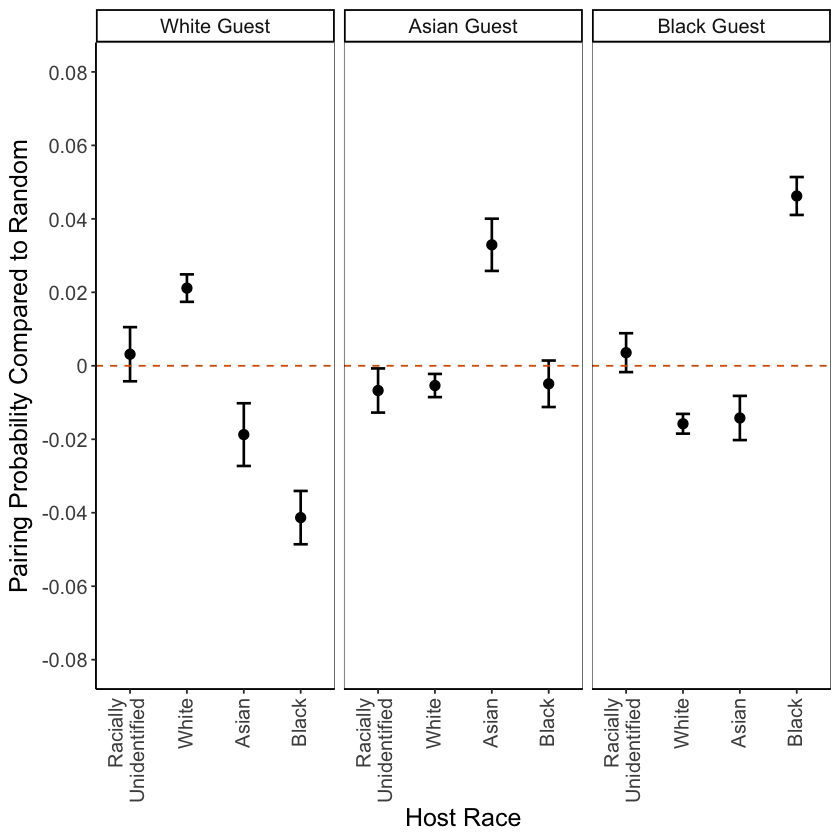

In [33]:
g

## Fig. S8B,E,H

- Replications of **Fig. 2** in the main

### 1.1 Choose sample

- Fully computed normed probabilities are available (check ***1.3*** without running code in ***1.2***)

In [75]:
df.tmp.obs=tmp_before.2017[, c("h.ethnicity", "g.ethnicity",
                               "top6.A", "top6.B", "top6.W"), with=FALSE]
df.tmp.obs$pairing.status=1
filename_obs="supp_fig_s8b_pairing.prob.obs_before_2017.RDS"
filename_diff="supp_fig_s8b_pairing.prob.diff_before_2017.RDS"
filename_pdf="supp_fig_s8b.pdf"

# df.tmp.obs=df.recent.by.old[, c("h.ethnicity", "g.ethnicity",
#                                 "top6.A", "top6.B", "top6.W"), with=FALSE]
# df.tmp.obs$pairing.status=1
# filename_obs="supp_fig_s8e_pairing.prob.obs_recent_by_old.RDS"
# filename_diff="supp_fig_s8e_pairing.prob.diff_recent_by_old.RDS"
# filename_pdf="supp_fig_s8e.pdf"

# df.tmp.obs=df.recent.by.new[, c("h.ethnicity", "g.ethnicity",
#                                 "top6.A", "top6.B", "top6.W"), with=FALSE]
# df.tmp.obs$pairing.status=1
# filename_obs="supp_fig_s8h_pairing.prob.obs_recent_by_new.RDS"
# filename_diff="supp_fig_s8h_pairing.prob.diff_recent_by_new.RDS"
# filename_pdf="supp_fig_s8h.pdf"

### 1.2 Compute normed probabilities for guest-host pairing combinations

In [76]:
#-Cap to 5 due to small N for Asian and Black guests on SRE 5 and 6
df.tmp.obs$top6.A=ifelse(df.tmp.obs$top6.A>5, 5, df.tmp.obs$top6.A)
df.tmp.obs$top6.B=ifelse(df.tmp.obs$top6.B>5, 5, df.tmp.obs$top6.B)
df.tmp.obs$top6.W=ifelse(df.tmp.obs$top6.W>5, 5, df.tmp.obs$top6.W)

df.tmp.ctf=create_ctf(df.tmp.obs)
df.obs.ctf=rbind(df.tmp.obs,df.tmp.ctf)

df.obs.ctf$sre[df.obs.ctf$g.ethnicity=="WHITE"]=df.obs.ctf$top6.W[df.obs.ctf$g.ethnicity=="WHITE"]
df.obs.ctf$sre[df.obs.ctf$g.ethnicity=="ASIAN"]=df.obs.ctf$top6.A[df.obs.ctf$g.ethnicity=="ASIAN"]
df.obs.ctf$sre[df.obs.ctf$g.ethnicity=="BLACK"]=df.obs.ctf$top6.B[df.obs.ctf$g.ethnicity=="BLACK"]
df.obs.ctf=df.obs.ctf[complete.cases(df.obs.ctf), ]

summary.pairing.prob.obs=summarySE(df.obs.ctf, measurevar="pairing.status",
                                   groupvars=c("h.ethnicity",
                                               "g.ethnicity",
                                               "sre"))

df.tmp.rnd=df.tmp.obs

#-Permutate g.ethnicity for n times to create a random baseline
#-to compare the difference between obeservations and random chances
#-as well as to create standard errors... .

start_time=Sys.time()

shuffle_time=1000
l_rand=list()
l_diff=list()
for(x in 1:shuffle_time){
    df.tmp=df.tmp.rnd
    df.tmp$g.ethnicity=df.tmp.rnd[sample(nrow(df.tmp.rnd)),]$g.ethnicity
    
    df.tmp.ctf=create_ctf(df.tmp)
    df.tmp.rnd.ctf=rbind(df.tmp,df.tmp.ctf)
    
    df.tmp.rnd.ctf$sre[df.tmp.rnd.ctf$g.ethnicity=="WHITE"]=df.tmp.rnd.ctf$top6.W[df.tmp.rnd.ctf$g.ethnicity=="WHITE"]
    df.tmp.rnd.ctf$sre[df.tmp.rnd.ctf$g.ethnicity=="ASIAN"]=df.tmp.rnd.ctf$top6.A[df.tmp.rnd.ctf$g.ethnicity=="ASIAN"]
    df.tmp.rnd.ctf$sre[df.tmp.rnd.ctf$g.ethnicity=="BLACK"]=df.tmp.rnd.ctf$top6.B[df.tmp.rnd.ctf$g.ethnicity=="BLACK"]
    
    df.tmp.rnd.ctf=df.tmp.rnd.ctf[complete.cases(df.tmp.rnd.ctf), ]
    
    df.tmp.pairing.prob.obs=summarySE(df.tmp.rnd.ctf, measurevar="pairing.status",
                                      groupvars=c("h.ethnicity", "g.ethnicity", "sre"))
    l_rand[[paste("g.rnd.ethnicity", x, sep=".")]]=df.tmp.pairing.prob.obs
    df.tmp.diff=df.tmp.pairing.prob.obs[,1:3]
    df.tmp.diff$prob.diff=summary.pairing.prob.obs$pairing.status - df.tmp.pairing.prob.obs$pairing.status
    l_diff[[paste("obs.rnd.diff", x, sep=".")]]=df.tmp.diff
}

df.pairing.prob.diff=do.call(rbind.data.frame, l_diff)

#-Save
saveRDS(summary.pairing.prob.obs, paste0(DIR,filename_obs))
saveRDS(df.pairing.prob.diff, paste0(DIR,filename_diff))

end_time=Sys.time()
end_time - start_time

Time difference of 2.230551 mins

### 1.3 Visualize normed probabilities by race of guest and host

In [71]:
#-Read
summary.pairing.prob.obs=readRDS(paste0(DIR,filename_obs))
df.pairing.prob.diff=readRDS(paste0(DIR,filename_diff))

In [77]:
summary.pairing.prob.diff=summarySE(df.pairing.prob.diff, measurevar="prob.diff",
                                    groupvars=c("h.ethnicity", "g.ethnicity", "sre"))

summary.pairing.prob.diff$ci=summary.pairing.prob.diff$sd*1.96

summary.pairing.prob.diff$h.ethnicity=ifelse(summary.pairing.prob.diff$h.ethnicity=="RA",
                                             "Racially Unidentified", summary.pairing.prob.diff$h.ethnicity)

re_from="\\b([[:alpha:]])([[:alpha:]]+)"
summary.pairing.prob.diff$h.ethnicity=gsub(re_from, "\\U\\1\\L\\2", summary.pairing.prob.diff$h.ethnicity, perl=TRUE)

summary.pairing.prob.diff$h.ethnicity=factor(summary.pairing.prob.diff$h.ethnicity,
                                             levels=c("Racially Unidentified","White","Asian","Black"),
                                             ordered=TRUE)

summary.pairing.prob.diff$g.ethnicity=factor(summary.pairing.prob.diff$g.ethnicity,
                                             levels=c("WHITE","ASIAN","BLACK"),
                                             ordered=TRUE)

summary.pairing.prob.diff$sre=factor(summary.pairing.prob.diff$sre)

In [78]:
tmp = summary.pairing.prob.diff[summary.pairing.prob.diff$h.ethnicity=="Racially Unidentified",]

l_guest.race.label=c(
    "BLACK"="Black Guest",
    "WHITE"="White Guest",
    "ASIAN"="Asian Guest")
cc=c("#899da4","#f1aa00","#be5d05","#2c2d4a")

dodge=position_dodge(width=0.5)
pdf(paste0("../output/",filename_pdf), width=3.17, height=5)
g = ggplot(tmp, aes(x=sre, y=prob.diff)) + 
  geom_line(position=dodge, size=0.75, aes(color=h.ethnicity, group=h.ethnicity)) +
  xlab("Number of Same-Race Endorsements\n(Out of 5 or More Front-Page Reviews)") + 
  # ylab("Pairing Probability Compared to Random") +
  ylab("") +
  geom_point(position=dodge, aes(color=h.ethnicity, group=h.ethnicity), size=2.5) +
  geom_errorbar(aes(ymin=prob.diff-ci, ymax=prob.diff+ci, color=h.ethnicity),
                size=0.75, width=0.15, position=dodge) +
  scale_color_manual(values=cc) +
  scale_x_discrete(labels=c("0","1","2","3","4","5+")) +
  facet_grid(g.ethnicity~., margins=FALSE, switch="y", scales="free_y",
             labeller=as_labeller(l_guest.race.label)) + labs(color="Host Race") +
             theme_classic() + theme(panel.border=element_rect(fill=NA, size=0.3)) +
  geom_hline(yintercept=0, linetype="dashed", color="#D55E00") +
  theme(legend.position="none",
        panel.grid.major=element_blank(),
        text=element_text(size=10))
plot(g)
dev.off()

pdf 
  2

In [79]:
fig_b = g
# fig_e = g
# fig_h = g

## Fig. S8C,F,I

- Replications of **Fig. 3** in the main

### 1.1 Choose sample

- Fully computed normed probabilities are available (check ***1.3*** without running code in ***1.2***)

In [101]:
df.tmp.obs=tmp_before.2017[, c("h.ethnicity", "g.ethnicity",
                               "top6.A", "top6.B", "top6.W"), with=FALSE]
df.tmp.obs$pairing.status=1
filename_obs="supp_fig_s8c_pairing.prob.obs_before_2017.RDS"
filename_diff="supp_fig_s8c_pairing.prob.diff_before_2017.RDS"
filename_pdf="supp_fig_s8c.pdf"

# df.tmp.obs=df.recent.by.old[, c("h.ethnicity", "g.ethnicity",
#                                 "top6.A", "top6.B", "top6.W"), with=FALSE]
# df.tmp.obs$pairing.status=1
# filename_obs="supp_fig_s8f_pairing.prob.obs_recent_by_old.RDS"
# filename_diff="supp_fig_s8f_pairing.prob.diff_recent_by_old.RDS"
# filename_pdf="supp_fig_s8f.pdf"

# df.tmp.obs=df.recent.by.new[, c("h.ethnicity", "g.ethnicity",
#                                 "top6.A", "top6.B", "top6.W"), with=FALSE]
# df.tmp.obs$pairing.status=1
# filename_obs="supp_fig_s8i_pairing.prob.obs_recent_by_new.RDS"
# filename_diff="supp_fig_s8i_pairing.prob.diff_recent_by_new.RDS"
# filename_pdf="supp_fig_s8i.pdf"

### 1.2 Compute normed probabilities for guest-host pairing combinations

In [94]:
#-Cap to 5 due to small N for Asian and Black guests on SRE 5 and 6
df.tmp.obs$top6.A=ifelse(df.tmp.obs$top6.A>5, 5, df.tmp.obs$top6.A)
df.tmp.obs$top6.B=ifelse(df.tmp.obs$top6.B>5, 5, df.tmp.obs$top6.B)
df.tmp.obs$top6.W=ifelse(df.tmp.obs$top6.W>5, 5, df.tmp.obs$top6.W)

df.tmp.ctf=create_ctf(df.tmp.obs)
df.obs.ctf=rbind(df.tmp.obs,df.tmp.ctf)

df.obs.ctf$sre[df.obs.ctf$g.ethnicity=="WHITE"]=df.obs.ctf$top6.W[df.obs.ctf$g.ethnicity=="WHITE"]
df.obs.ctf$sre[df.obs.ctf$g.ethnicity=="ASIAN"]=df.obs.ctf$top6.A[df.obs.ctf$g.ethnicity=="ASIAN"]
df.obs.ctf$sre[df.obs.ctf$g.ethnicity=="BLACK"]=df.obs.ctf$top6.B[df.obs.ctf$g.ethnicity=="BLACK"]
df.obs.ctf=df.obs.ctf[complete.cases(df.obs.ctf), ]

summary.pairing.prob.obs=summarySE(df.obs.ctf, measurevar="pairing.status",
                                   groupvars=c("h.ethnicity",
                                               "g.ethnicity",
                                               "sre"))

df.tmp.rnd=df.tmp.obs

#-Permutate g.ethnicity for n times to create a random baseline
#-to compare the difference between obeservations and random chances
#-as well as to create standard errors... .

start_time=Sys.time()

shuffle_time=1000
l_rand=list()
l_diff=list()
for(x in 1:shuffle_time){
    df.tmp=df.tmp.rnd
    df.tmp$g.ethnicity=df.tmp.rnd[sample(nrow(df.tmp.rnd)),]$g.ethnicity
    
    df.tmp.ctf=create_ctf(df.tmp)
    df.tmp.rnd.ctf=rbind(df.tmp,df.tmp.ctf)
    
    df.tmp.rnd.ctf$sre[df.tmp.rnd.ctf$g.ethnicity=="WHITE"]=df.tmp.rnd.ctf$top6.W[df.tmp.rnd.ctf$g.ethnicity=="WHITE"]
    df.tmp.rnd.ctf$sre[df.tmp.rnd.ctf$g.ethnicity=="ASIAN"]=df.tmp.rnd.ctf$top6.A[df.tmp.rnd.ctf$g.ethnicity=="ASIAN"]
    df.tmp.rnd.ctf$sre[df.tmp.rnd.ctf$g.ethnicity=="BLACK"]=df.tmp.rnd.ctf$top6.B[df.tmp.rnd.ctf$g.ethnicity=="BLACK"]
    
    df.tmp.rnd.ctf=df.tmp.rnd.ctf[complete.cases(df.tmp.rnd.ctf), ]
    
    df.tmp.pairing.prob.obs=summarySE(df.tmp.rnd.ctf, measurevar="pairing.status",
                                      groupvars=c("h.ethnicity", "g.ethnicity", "sre"))
    l_rand[[paste("g.rnd.ethnicity", x, sep=".")]]=df.tmp.pairing.prob.obs
    df.tmp.diff=df.tmp.pairing.prob.obs[,1:3]
    df.tmp.diff$prob.diff=summary.pairing.prob.obs$pairing.status - df.tmp.pairing.prob.obs$pairing.status
    l_diff[[paste("obs.rnd.diff", x, sep=".")]]=df.tmp.diff
}

df.pairing.prob.diff=do.call(rbind.data.frame, l_diff)

#-Save
saveRDS(summary.pairing.prob.obs, paste0(DIR,filename_obs))
saveRDS(df.pairing.prob.diff, paste0(DIR,filename_diff))

end_time=Sys.time()
end_time - start_time

Time difference of 2.155234 mins

### 1.3 Visualize normed probabilities by race of guest and host

In [102]:
#-Read
summary.pairing.prob.obs=readRDS(paste0(DIR,filename_obs))
df.pairing.prob.diff=readRDS(paste0(DIR,filename_diff))

In [103]:
summary.pairing.prob.diff=summarySE(df.pairing.prob.diff, measurevar="prob.diff",
                                    groupvars=c("h.ethnicity", "g.ethnicity", "sre"))

summary.pairing.prob.diff$ci=summary.pairing.prob.diff$sd*1.96

#-Only for the binary visualization!
tmp = df.pairing.prob.diff[df.pairing.prob.diff$h.ethnicity!="RA",]

tmp$h.ethnicity=ifelse(tmp$h.ethnicity==tmp$g.ethnicity,
                       "Same-Race", "Other-Race")

summary.pairing.prob.diff=summarySE(tmp, measurevar="prob.diff",
                                    groupvars=c("h.ethnicity", "g.ethnicity", "sre"))

summary.pairing.prob.diff$ci=summary.pairing.prob.diff$sd*1.96

summary.pairing.prob.diff$h.ethnicity=factor(summary.pairing.prob.diff$h.ethnicity,
                                             levels=c("Same-Race","Other-Race"),
                                             ordered=TRUE)

summary.pairing.prob.diff$g.ethnicity=factor(summary.pairing.prob.diff$g.ethnicity,
                                             levels=c("WHITE","ASIAN","BLACK"),
                                             ordered=TRUE)

summary.pairing.prob.diff$sre=factor(summary.pairing.prob.diff$sre)

In [104]:
l_guest.race.label=c(
    "BLACK"="Black Guest",
    "WHITE"="White Guest",
    "ASIAN"="Asian Guest")

cc=c("#be5d05","#2c2d4a")

dodge=position_dodge(width=0.5)
pdf(paste0("../output/",filename_pdf), width=3.17, height=4)
g = ggplot(summary.pairing.prob.diff, aes(x=sre, y=prob.diff)) + 
  geom_line(position=dodge, size=0.75, aes(color=h.ethnicity, group=h.ethnicity)) +
  xlab("Number of Same-Race Endorsements\n(Out of 5 or More Front-Page Reviews)") + 
  # ylab("Pairing Probability Compared to Random") +
  ylab("") +
  geom_point(position=dodge, aes(color=h.ethnicity, group=h.ethnicity), size=2.5) +
  geom_errorbar(aes(ymin=prob.diff-ci, ymax=prob.diff+ci, color=h.ethnicity),
                size=0.9, width=0.25, position=dodge) +
  scale_color_manual(values=cc) +
  scale_x_discrete(labels=c("0","1","2","3","4","5+")) +
  facet_grid(g.ethnicity~., margins=FALSE, switch="y", scales="free_y",
             labeller=as_labeller(l_guest.race.label)) + labs(color="Host Race") +
             theme_classic() + theme(panel.border=element_rect(fill=NA, size=0.3)) +
  # coord_cartesian(ylim=c(-0.3,0.4)) +
  geom_hline(yintercept=0, linetype="dashed", color="#D55E00") +
  theme(legend.direction="vertical",
        # legend.position=c(0.6,0.77),
        legend.position="none",
        legend.justification="left",
        legend.margin=margin(0, unit="cm"),
        legend.spacing.y=unit(0.1,"cm"),
        legend.key.size=unit(0.85,"lines"),
        panel.grid.major=element_blank(),
        text=element_text(size=10))
plot(g)
dev.off()

pdf 
  2

In [105]:
fig_c = g
# fig_f = g
# fig_i = g

## Compile all the figures

In [107]:
library(cowplot)

g <- plot_grid(fig_a,fig_b,fig_c,
               fig_d,fig_e,fig_f,
               fig_g,fig_h,fig_i,
               labels="AUTO", label_size=12,
               ncol=3)

In [108]:
pdf(file="../output/supp_fig_s8.pdf", width=9.5, height=4*3)
print(g)
dev.off()

pdf 
  2